# Introduction

I will use this notebook for the relax take home challenge. An "adopted user" is a user who has logged into the product on three separate days in at least one sevenday period, I will identify which factors predict future user
adoption the most.

# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

# User Data Features

name: the user's name

object_id: the user's id

email: email address

creation_source: how their account was created. This takes on one of 5 values:

  1-PERSONAL_PROJECTS: invited to join another user's personal workspace
  
  2-GUEST_INVITE: invited to an organization as a guest (limited permissions)
  
  3-ORG_INVITE: invited to an organization (as a full member)
  
  4-SIGNUP: signed up via the website
  
  5-SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
  
creation_time: when they created their account

last_session_creation_time: unix timestamp of last login

opted_in_to_mailing_list: whether they have opted into receiving marketing emails

enabled_for_marketing_drip: whether they are on the regular marketing email drip

org_id: the organization (group of users) they belong to

invited_by_user_id: which user invited them to join (if applicable)."


## 1.Load the 'takehome_users.csv' as Users

In [2]:
Users = pd.read_csv('/Users/hayaldargin/Desktop/Springboard/Springboard_Work/Unit_26/Unit26_2_Ultimate Technologies Inc./relax_challenge/takehome_users.csv', encoding='latin-1')
Users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [3]:
Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
Users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


First, I want to create a datetime feature for 'last_session_creation_time' and 'creation_time' Columns.

In [5]:
Users['last_session_creation_time'] = pd.to_datetime(Users['last_session_creation_time'])
Users['creation_time'] = pd.to_datetime(Users['creation_time'])
Users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


# Engagement Data Features

A usage summary table ( "takehome_user_engagement" ) has a row for each day
that a user logged into the product.

## Load the "takehome_user_engagement" as User_Engagement

In [6]:
User_Engagement = pd.read_csv('/Users/hayaldargin/Desktop/Springboard/Springboard_Work/Unit_26/Unit26_2_Ultimate Technologies Inc./relax_challenge/takehome_user_engagement.csv', encoding='latin-1')
User_Engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [7]:
User_Engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
User_Engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


First thing I want to do in engagement data set is to convert time_stamp column into date time. 

In [9]:
#Convert time_stamp into datetime object
User_Engagement['time_stamp'] = pd.to_datetime(User_Engagement['time_stamp'])
User_Engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Now I want to set time_stamp column as my index and find out if users had loogged on 3 times or more as the challange is asking.

In [10]:
User_Engagement['time_stamp'] = User_Engagement['time_stamp'].dt.floor(
    'd').astype(np.int64)
User_Engagement = User_Engagement.sort_values(
    ['user_id', 'time_stamp']).drop_duplicates()


In [11]:
q = User_Engagement.groupby('user_id')['time_stamp'].rolling(window=3)
qq = pd.to_timedelta((q.max() - q.min())).dt.days
adopted_user = qq[qq < 8].index.get_level_values('user_id').tolist()

In [12]:
#Create adopted_user and print
adopted_user = np.unique(adopted_user)
print('Number of Adopted Users is:{}'.format(len(adopted_user)))

Number of Adopted Users is:1656


Now that i know there are 1656 adopted users who logged on 3 or more times, I want to predict which features are more important to become an adopted user.

In [13]:
Users['adopted'] = Users.object_id.apply(lambda x: 1 if x in adopted_user else 0)
Users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,0


I will drop the columns that are not gping to be part of the prediction model such as name, email, etc. Also we will drop the columns we already used creating adopted user column (creation_time, last_session_creation_time). Last, we will drop invited_by_user_id columns since there are a lot of NAN data in that.

In [14]:
Users = Users.drop(['creation_time', 'name', 'email', 'last_session_creation_time',
              'invited_by_user_id', 'object_id'], axis=1)
Users.head()


,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


I want to see the correlation rates betwwen features teherefore i will create dummy variables.

In [15]:
Users = pd.get_dummies(Users, drop_first=True) # add dummy for correlation map
Users.head()


,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0,0
1,0,0,1,1,1,0,0,0
2,0,0,94,0,1,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,193,0,0,0,0,0


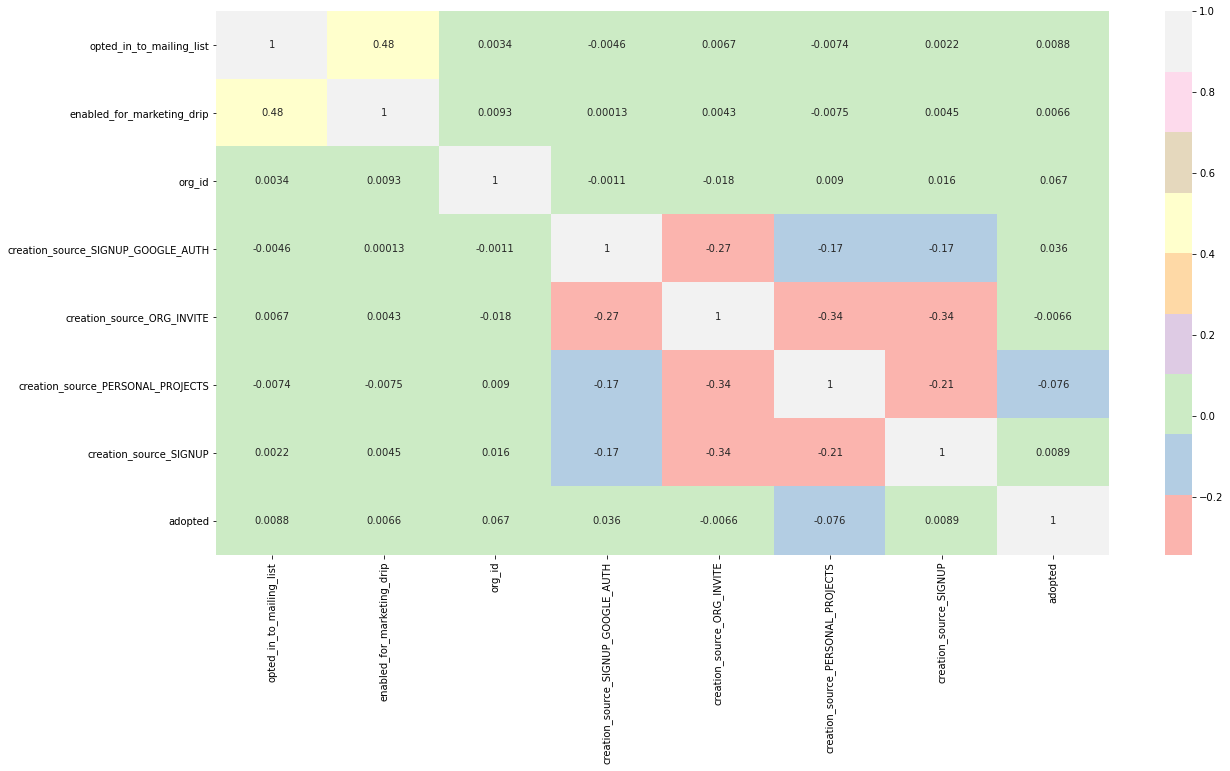

In [16]:
cols = list(Users.columns.values)
cols[3], cols[-1] = cols[-1], cols[3]
Users = Users[cols]
corrmat = Users.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 10))
g = sns.heatmap(Users[top_corr_features].corr(), annot=True, cmap="Pastel1")


As we can see from the correlation heatmapabove targeted column adopted is having the highest correlation with org_id which is the organization (group of users) they belong to. 

# Split data into traning and test data sets

In [17]:
X = Users.drop('adopted', axis=1)
y= Users.adopted


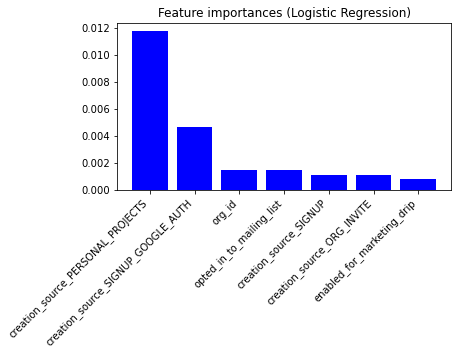

In [18]:
# fitting logistic regression model
clf = LogisticRegressionCV(max_iter=3000) 
clf.fit(X, y)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(7), coefs[indices[:12]],
       color="b", align="center")
plt.xticks(range(7), Users.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

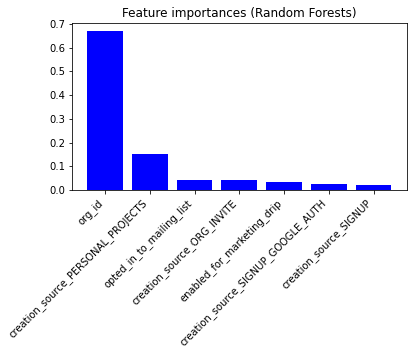

In [19]:
# Fitting Random Forest
clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6)
clf.fit(X, y)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(7), coefs[indices[:12]],
       color="b", align="center")
plt.xticks(range(7), Users.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

it is clear that org_id(the organization (group of users) they belong to) and creation_source: how their account was created are the most important fatures in predicting the user adoption. 